In [41]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.spatial.transform import Rotation
import laspy
import pandas as pd
import os
from pyproj import CRS, Transformer
from tqdm import tqdm
import sys
sys.path.append('../src/')
import plotly.express as px

# 1. NaviEdit -> LAZ -> Point cloud

In [49]:
def normalize_pc(points):
	centroid = np.mean(points, axis=0)
	points -= centroid
	furthest_distance = np.max(np.sqrt(np.sum(abs(points)**2,axis=-1)))
	points /= furthest_distance

	return points

In [77]:
las = laspy.read('/home/li/Downloads/EM2040-0030-L03S01-20220119-193553.las')
points = np.vstack((las.X, las.Y, las.Z)).transpose()
points = points * las.header.scale + las.header.offset
print(points.shape)
print(points[0])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
downpcd = pcd.voxel_down_sample(voxel_size=2)
downpcd.points
#o3d.visualization.draw_geometries([downpcd])

aug_noise = .1
rot_factor = 1

down_points = np.asarray(downpcd.points)
print(down_points.shape)
src = np.random.permutation(down_points[:10000, :])[:2000, :]
src += (np.random.rand(*src.shape) - 0.5) * aug_noise
src = normalize_pc(src)
print(src.shape)
torch.save(src, "assets/test.pth")

# rotate the point cloud
trg = np.random.permutation(down_points[7000:18000, :])[:2000, :]
euler_ab=np.random.rand(3)*np.pi*2/rot_factor # anglez, angley, anglex
rot_ab= Rotation.from_euler('zyx', euler_ab).as_matrix()
trg += (np.random.rand(*trg.shape) - 0.5) * aug_noise
trg =np.matmul(rot_ab,trg.T).T
trg = normalize_pc(trg)
torch.save(trg, "assets/test1.pth")

(914502, 3)
[ 4.60723066e+05  1.77812617e+06 -9.04019980e+02]
(155618, 3)
(2000, 3)


In [64]:
#pcd = o3d.io.read_point_cloud("assets/cloud_bin_21.pth")
data = torch.load("assets/test.pth").astype(np.float32)
data1 = torch.load("assets/test1.pth").astype(np.float32)
print(data.shape, data1.shape)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data)

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(data1)

o3d.visualization.draw_geometries([pcd, pcd1])

(2000, 3) (2000, 3)


In [67]:
np.array(pcd.points)

array([[ 0.33896023, -0.43553659,  0.04193757],
       [ 0.00954625,  0.34624669, -0.0106827 ],
       [ 0.31984845,  0.06498687,  0.02973026],
       ...,
       [-0.17993498, -0.28495371, -0.03518974],
       [-0.53547716, -0.78250396, -0.02612695],
       [-0.39036116, -0.24462132, -0.03694123]])

# 2. NaviEdit -> XYZ data beam -> Point cloud
- Why?
    1. (Important) .las exports points in (num_points, 3) and it's a bit hard to tell which points are from the same beam, which makes it a bit difficult to separete based on time + space
    2. (Not so important) the timestamp from the .las export seems to be off (~year 1990)...

## 2.1 xyz_pings -> point cloud directly (ignore beam nbr)

In [2]:
def process_xyz_pings_file(filepath):
    """Read a .xyz file containing info about each beam hits and return a processed dataframe
    where each row contains info for 1 MBES swath"""
    naviedit_pings = pd.read_csv(filepath, delimiter='\t', header=0)

    # Aggregate xyz hits of each beam into a hits array
    naviedit_pings['hit'] = naviedit_pings[['X', 'Y',
                                            'Z']].apply(lambda row: list(row),
                                                        axis=1)

    # Parse string datetime values and produce a datetime object
    naviedit_pings['time_string'] = naviedit_pings[[
        'yyyy', 'mmddhhmm', 'ss.ss'
    ]].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
    naviedit_pings['time_string'] = pd.to_datetime(
        naviedit_pings['time_string'], format='%Y.%m%d%H%M.0%S.%f')
    naviedit_pings['time_stamp'] = naviedit_pings['time_string'].map(
        pd.Timestamp.timestamp)

    # Group the beams by Ping No -> aggregate hits from the same ping into a list
    beams = naviedit_pings.groupby('Ping No').agg({'hit': list})

    # Get unique pings
    ping_info = naviedit_pings[[
        'time_string', 'time_stamp', 'Ping No', 'Tide', 'Heading', 'Heave',
        'Pitch', 'Roll'
    ]].drop_duplicates().set_index('Ping No')

    # Final results with 1 row = 1 MBES swath
    mbes_ping_result = ping_info.join(beams)
    return mbes_ping_result


In [10]:
df = process_xyz_pings_file('/home/li/Downloads/EM2040-0030-L03S01-20220119-193553.xyz')
df.head()

,time_string,time_stamp,Tide,Heading,Heave,Pitch,Roll,hit
Ping No,,,,,,,,
39909,2022-01-19 19:35:53.060,1.642621e+09,0.0,271.83,0.0,11.702,-1.58,"[[460722.21, 1778135.04, 904.33], [460722.14, ..."
39910,2022-01-19 19:35:53.410,1.642621e+09,0.0,271.80,0.0,12.408,-1.61,"[[460720.75, 1778144.44, 904.97], [460720.69, ..."
39911,2022-01-19 19:35:53.780,1.642621e+09,0.0,271.78,0.0,13.165,-1.64,"[[460720.02, 1778146.45, 904.93], [460719.95, ..."
39912,2022-01-19 19:35:54.140,1.642621e+09,0.0,271.75,0.0,13.942,-1.69,"[[460719.88, 1778143.95, 904.88], [460719.79, ..."
39913,2022-01-19 19:35:54.500,1.642621e+09,0.0,271.72,0.0,14.718,-1.71,"[[460718.38, 1778150.95, 904.99], [460718.21, ..."


## 2.2 xyz_pings -> Numpy array with shape (nbr_pings, nbr_beams, 3)

In [14]:
naviedit_pings = pd.read_csv('/home/li/Downloads/EM2040-0030-L03S01-20220119-193553.xyz', delimiter='\t', header=0)
naviedit_pings.head()

,yyyy,mmddhhmm,ss.ss,Ping No,Beam No,X,Y,Z,Tide,Heading,Heave,Pitch,Roll
0,2022,1191935,53.06,39909,24,460722.21,1778135.04,904.33,0.0,271.83,0.0,11.702,-1.58
1,2022,1191935,53.06,39909,25,460722.14,1778135.93,904.26,0.0,271.83,0.0,11.702,-1.58
2,2022,1191935,53.06,39909,26,460722.07,1778136.49,904.41,0.0,271.83,0.0,11.702,-1.58
3,2022,1191935,53.06,39909,27,460721.99,1778137.07,904.58,0.0,271.83,0.0,11.702,-1.58
4,2022,1191935,53.06,39909,28,460721.93,1778137.96,904.46,0.0,271.83,0.0,11.702,-1.58


In [38]:
nbr_pings = naviedit_pings['Ping No'].unique().shape[0]
max_nbr_beams = 400
print(f'nbr pings: {nbr_pings}, max nbr beams: {max_nbr_beams}')
naviedit_pings['ping_id'] = naviedit_pings['Ping No'] - naviedit_pings['Ping No'].min()

nbr pings: 2460, max nbr beams: 400


In [78]:
# iterate through naviedit_pings and populate pings_array
pings_array = np.zeros((nbr_pings, max_nbr_beams, 3))
for i, row in naviedit_pings.iterrows():
    ping_id = row['ping_id'].astype(int)
    beam_id = row['Beam No'].astype(int)
    pings_array[ping_id, beam_id, :] = row[['X', 'Y', 'Z']]

In [120]:
section = pings_array[:500, :200, :].reshape(-1, 3)
tmp2 = pings_array[:500, 200:, :].reshape(-1, 3)
mask = ~np.all(section == 0, axis=1)
mask2 = ~np.all(tmp2 == 0, axis=1)
print(f'% beams with data: {np.count_nonzero(mask)/section.shape[0]*100:.2f}%')
tmp_pcd = o3d.geometry.PointCloud()
tmp_pcd.points = o3d.utility.Vector3dVector(section[mask, :])
tmp2_pcd = o3d.geometry.PointCloud()
tmp2_pcd.points = o3d.utility.Vector3dVector(tmp2[mask2, :])
o3d.visualization.draw_geometries([tmp_pcd, tmp2_pcd])

% beams with data: 84.46%


In [34]:
def naviedit_xyz_to_npy(filepath, max_nbr_beams=400):
    """Given a .xyz file exported by NaviEdit with xyz info for each beam hit,
    return a numpy array of shape (nbr_pings, max_nbr_beams, 3) where 
    array[i, j, :] = [x, y, z] of the jth beam hit in the ith ping. Beam with no
    hit will be filled with 0s."""

    pings = pd.read_csv(filepath, delimiter='\t', header=0)
    # nbr_pings = pings['Ping No'].max() - pings['Ping No'].min() + 1
    nbr_pings = pings['Ping No'].unique().shape[0]
    print(f'nbr pings: {nbr_pings}, max nbr beams: {max_nbr_beams}')
    # pings['ping_id'] = pings['Ping No'] - pings['Ping No'].min()

    # iterate through naviedit_pings and populate pings_array
    pings_array = np.zeros((nbr_pings, max_nbr_beams, 3))
    ping_id = 0
    prev_ping_no = pings.iloc[0]['Ping No']
    for i, row in tqdm(pings.iterrows(), total=pings.shape[0]):
        ping_no = row['Ping No'].astype(int)
        if ping_no != prev_ping_no:
            ping_id += 1
            prev_ping_no = ping_no
        beam_id = row['Beam No'].astype(int)
        pings_array[ping_id, beam_id, :] = row[['X', 'Y', 'Z']]

    return pings_array

def plot_pcl_section(pings_array, start_ping=0, end_ping=-1, start_beam=0, end_beam=-1,
                     voxel_size=1, capture=False, save_path=None):
    """Plot a section of the pings_array"""
    section = pings_array[start_ping:end_ping, start_beam:end_beam, :].reshape(-1, 3)
    nonzero_mask = ~np.all(section == 0, axis=1)
    print(f'ping range: {start_ping} - {end_ping}, beam range: {start_beam} - {end_beam}')
    print(f'% beams with data: {np.count_nonzero(nonzero_mask)/section.shape[0]*100:.2f}%')
    section_pcd = o3d.geometry.PointCloud()
    section_pcd.points = o3d.utility.Vector3dVector(section[nonzero_mask, :])
    section_pcd = section_pcd.voxel_down_sample(voxel_size=voxel_size)

    if not capture:
        o3d.visualization.draw_geometries([section_pcd])
    else:
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.add_geometry(section_pcd)
        vis.poll_events()
        vis.update_renderer()
        vis.capture_screen_image(save_path)

In [37]:
file70_pings_array = naviedit_xyz_to_npy(
    '/home/li/pcl-registration/Datasets/NBP22-mission2-DotsonEast/pings-xyz/EM2040-0070-L12S01-20220120-045451.xyz'
)
plot_pcl_section(file70_pings_array)
np.save('/home/li/pcl-registration/Datasets/NBP22-mission2-DotsonEast/EM2040-0070-L12S01-20220120-045451.npy', file70_pings_array)

nbr pings: 2390, max nbr beams: 400


100%|██████████| 834832/834832 [03:31<00:00, 3944.72it/s]


ping range: 0 - -1, beam range: 0 - -1
% beams with data: 87.42%


In [4]:
folders = [#'/home/li/pcl-registration/Datasets/NBP22-mission2-DotsonEast/',
           #'/home/li/pcl-registration/Datasets/NBP22-mission3-DotsonWest/',
           '/home/li/pcl-registration/Datasets/NBP22-mission4-DotsonMid/']
for folder in folders:
    print(f'Processing {folder}...')
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.xyz'):
            out_filename = f'{filename.split(".")[0]}'
            if (os.path.exists(os.path.join(folder, f'{out_filename}.npy'))):
                print(f'{out_filename}.npy already exists, skipping...')
                continue
            print(f'processing {filename}')
            pings_array = naviedit_xyz_to_npy(folder + filename)
            np.save(os.path.join(folder, f'{out_filename}.npy'), pings_array)
            print(f'saved {out_filename}.npy')
            plot_pcl_section(pings_array,
                            capture=True,
                            save_path=os.path.join(folder, f'{out_filename}.png'))
            

Processing /home/li/pcl-registration/Datasets/NBP22-mission4-DotsonMid/...
processing EM2040-0017-pumpco2o-20220128-003109.xyz
nbr pings: 2401, max nbr beams: 400
saved EM2040-0017-pumpco2o-20220128-003109.npy
ping range: 0 - -1, beam range: 0 - -1
% beams with data: 89.34%
processing EM2040-0018-pumpco2o-20220128-004609.xyz
nbr pings: 2487, max nbr beams: 400
saved EM2040-0018-pumpco2o-20220128-004609.npy
ping range: 0 - -1, beam range: 0 - -1
% beams with data: 90.48%
processing EM2040-0019-pumpco2o-20220128-010109.xyz
nbr pings: 2485, max nbr beams: 400
saved EM2040-0019-pumpco2o-20220128-010109.npy
ping range: 0 - -1, beam range: 0 - -1
% beams with data: 88.91%
processing EM2040-0020-pumpco2o-20220128-011609.xyz
nbr pings: 2456, max nbr beams: 400
saved EM2040-0020-pumpco2o-20220128-011609.npy
ping range: 0 - -1, beam range: 0 - -1
% beams with data: 89.25%
processing EM2040-0021-pumpco2o-20220128-013109.xyz
nbr pings: 2598, max nbr beams: 400
saved EM2040-0021-pumpco2o-20220128-0

In [53]:
filename = '/home/li/pcl-registration/Datasets/NBP22-mission3-DotsonWest/EM2040-0086-L11S01-20220123-062247.xyz'
df = pd.read_csv(filename, delimiter='\t', header=0)

In [61]:
#plot_pcl_section(tmp, start_ping=0, end_ping=500, start_beam=0, end_beam=100, capture=True, save_path=f'{filename.split(".")[0]}.png')
print(f"nbr pings: {df['Ping No'].max() - df['Ping No'].min() + 1}")
df['Ping No'].max() - df['Ping No'].min()
df.tail()

nbr pings: 126.0


,yyyy,mmddhhmm,ss.ss,Ping No,Beam No,X,Y,Z,Tide,Heading,Heave,Pitch,Roll,ping_id
46011,2022,1230623,37.84,65151.0,322.0,441032.71,1763357.83,787.00,0.0,199.73,0.0,6.69,-1.59,125.0
46012,2022,1230623,37.84,65151.0,323.0,441028.76,1763359.11,789.99,0.0,199.73,0.0,6.69,-1.59,125.0
46013,2022,1230623,37.84,65151.0,326.0,441017.87,1763362.66,797.71,0.0,199.73,0.0,6.69,-1.59,125.0
46014,2022,1230623,37.84,65151.0,327.0,441014.65,1763363.73,799.82,0.0,199.73,0.0,6.69,-1.59,125.0
46015,2022,1230623,37.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Merge Navigation Data

## 3.1 Testing with one file

In [2]:
motion = pd.read_csv(
    '../src/mbes_data/data/nbp22-mission2-dotson-east/motion/EM2040-0012-pumpco2o-20220119-154234.csv'
)
motion.head()

,Date,Time,Lat,Long,Depth,Heading,Pitch,Roll
0,2022-01-19,15:42:33.723,-73.990000,-111.797926,350.52,270.25,-1.35,-1.84
1,2022-01-19,15:42:33.923,-73.989983,-111.798010,350.54,270.23,-1.25,-1.88
2,2022-01-19,15:42:34.123,-73.989983,-111.798022,350.57,270.21,-1.17,-1.92
3,2022-01-19,15:42:34.323,-73.989983,-111.798035,350.60,270.20,-1.08,-1.93
4,2022-01-19,15:42:34.523,-73.989983,-111.798048,350.61,270.19,-1.00,-1.95


In [3]:
motion['datetime'] = pd.to_datetime(motion['Date'] + ' ' + motion['Time'],
                                    format='%Y-%m-%d %H:%M:%S.%f')
motion.head()

,Date,Time,Lat,Long,Depth,Heading,Pitch,Roll,datetime
0,2022-01-19,15:42:33.723,-73.990000,-111.797926,350.52,270.25,-1.35,-1.84,2022-01-19 15:42:33.723
1,2022-01-19,15:42:33.923,-73.989983,-111.798010,350.54,270.23,-1.25,-1.88,2022-01-19 15:42:33.923
2,2022-01-19,15:42:34.123,-73.989983,-111.798022,350.57,270.21,-1.17,-1.92,2022-01-19 15:42:34.123
3,2022-01-19,15:42:34.323,-73.989983,-111.798035,350.60,270.20,-1.08,-1.93,2022-01-19 15:42:34.323
4,2022-01-19,15:42:34.523,-73.989983,-111.798048,350.61,270.19,-1.00,-1.95,2022-01-19 15:42:34.523


In [25]:
# Checking that the transformation from (lat, lon) to UTM12S is correct
from pyproj import CRS, Transformer
crs_4326 = CRS.from_epsg(4326)
crs_utm12s = CRS.from_epsg(32712)
transformer = get_crs_transformer()

for file in sorted(os.listdir('../src/mbes_data/data/nbp22-mission2-dotson-east/utm-geoinfo/')):
    if file.endswith('.txt'):
        utm_info = pd.read_csv(
            f'../src/mbes_data/data/nbp22-mission2-dotson-east/utm-geoinfo/{file}',
            sep=' ',
            names=['Date', 'Time', 'Kp',
                     'Easting', 'Northing', 
                     'Longitude', 'Latitude'],
            skiprows=1 if 'EM2040-0012' in file else None
        )
    for i, row in utm_info.iterrows():
        lat, lon, easting, northing = row['Latitude'], row['Longitude'], row['Easting'], row['Northing']
        transformed_easting, transform_northing = transformer.transform(lat, lon)
        if not np.isclose(easting, transformed_easting) or not np.isclose(northing, transform_northing):
            print(f'File {file} Row {i} easting/northing mismatch: {easting}, {northing} vs {transformed_easting}, {transform_northing}')

In [24]:
def get_crs_transformer(from_crs: int=4326, to_crs: int=32712) -> Transformer:
    """Returns a pyproj.Transformer object that can be used to convert from one CRS to another.
    
    Args:
        from_crs: EPSG code of the source CRS
                  default: 4326 (WGS84)
        to_crs: EPSG code of the target CRS
                default: 32712 (WGS84 UTM zone 12S) """
    from_crs = CRS.from_epsg(from_crs)
    to_crs = CRS.from_epsg(to_crs)
    transformer = Transformer.from_crs(from_crs, to_crs)
    return transformer

In [27]:
transformer = get_crs_transformer()
motion['Easting'], motion['Northing'] = transformer.transform(motion['Lat'].values, motion['Long'].values)
motion.head()

,Date,Time,Lat,Long,Depth,Heading,Pitch,Roll,datetime,Easting,Northing
0,2022-01-19,15:42:33.723,-73.990000,-111.797926,350.52,270.25,-1.35,-1.84,2022-01-19 15:42:33.723,475436.072380,1.788913e+06
1,2022-01-19,15:42:33.923,-73.989983,-111.798010,350.54,270.23,-1.25,-1.88,2022-01-19 15:42:33.923,475433.458211,1.788915e+06
2,2022-01-19,15:42:34.123,-73.989983,-111.798022,350.57,270.21,-1.17,-1.92,2022-01-19 15:42:34.123,475433.085438,1.788915e+06
3,2022-01-19,15:42:34.323,-73.989983,-111.798035,350.60,270.20,-1.08,-1.93,2022-01-19 15:42:34.323,475432.703653,1.788915e+06
4,2022-01-19,15:42:34.523,-73.989983,-111.798048,350.61,270.19,-1.00,-1.95,2022-01-19 15:42:34.523,475432.306552,1.788915e+06


## 3.2 Merge UTM, latlon and depth for all motion files

In [3]:
def get_crs_transformer(from_crs: int=4326, to_crs: int=32712) -> Transformer:
    """Returns a pyproj.Transformer object that can be used to convert from one CRS to another.
    
    Args:
        from_crs: EPSG code of the source CRS
                  default: 4326 (WGS84)
        to_crs: EPSG code of the target CRS
                default: 32712 (WGS84 UTM zone 12S) """
    from_crs = CRS.from_epsg(from_crs)
    to_crs = CRS.from_epsg(to_crs)
    transformer = Transformer.from_crs(from_crs, to_crs)
    return transformer

In [4]:
def merge_motion_data():
    transformer = get_crs_transformer()
    processed_motion_folder = '../src/mbes_data/data/nbp22-mission2-dotson-east/processed-motion/'
    os.makedirs(processed_motion_folder, exist_ok=True)

    for f in tqdm(sorted(os.listdir('../src/mbes_data/data/nbp22-mission2-dotson-east/motion/'))):
        if f.endswith('.csv'):
            motion = pd.read_csv(
                f'../src/mbes_data/data/nbp22-mission2-dotson-east/motion/{f}'
            )
            motion['datetime'] = pd.to_datetime(motion['Date'] + ' ' + motion['Time'],
                                                format='%Y-%m-%d %H:%M:%S.%f')
            motion['Easting'], motion['Northing'] = transformer.transform(motion['Lat'].values, motion['Long'].values)
            motion.to_csv(os.path.join(processed_motion_folder, f), index=False)

    merged_df = pd.DataFrame()
    for f in sorted(os.listdir('../src/mbes_data/data/nbp22-mission2-dotson-east/processed-motion/')):
        if f == 'merged.csv':
            continue
        motion = pd.read_csv(
            f'../src/mbes_data/data/nbp22-mission2-dotson-east/processed-motion/{f}'
        )
        motion['Filename'] = int(f.split('-')[1])
        merged_df = pd.concat([merged_df, motion])
    merged_df.to_csv('../src/mbes_data/data/nbp22-mission2-dotson-east/processed-motion/merged.csv', index=False)
    return merged_df

merged_df = pd.read_csv(
    '../src/mbes_data/data/nbp22-mission2-dotson-east/processed-motion/merged.csv'
)
merged_df.head()

,Date,Time,Lat,Long,Depth,Heading,Pitch,Roll,datetime,Easting,Northing,Filename
0,2022-01-19,15:42:33.723,-73.990000,-111.797926,350.52,270.25,-1.35,-1.84,2022-01-19 15:42:33.723,475436.072380,1.788913e+06,12
1,2022-01-19,15:42:33.923,-73.989983,-111.798010,350.54,270.23,-1.25,-1.88,2022-01-19 15:42:33.923,475433.458211,1.788915e+06,12
2,2022-01-19,15:42:34.123,-73.989983,-111.798022,350.57,270.21,-1.17,-1.92,2022-01-19 15:42:34.123,475433.085438,1.788915e+06,12
3,2022-01-19,15:42:34.323,-73.989983,-111.798035,350.60,270.20,-1.08,-1.93,2022-01-19 15:42:34.323,475432.703653,1.788915e+06,12
4,2022-01-19,15:42:34.523,-73.989983,-111.798048,350.61,270.19,-1.00,-1.95,2022-01-19 15:42:34.523,475432.306552,1.788915e+06,12


## 3.3 Determine Train/Val/Test split

In [72]:
train_sec = (12, 76)
test_sec = (77, 84)
val_sec = (85, 95)

In [5]:
def get_percentage_data_bewteen(merged_df, begin, end):
    subset = merged_df[merged_df['Filename'].between(begin, end)]
    print(f'Between files { begin} and {end}:\n'
          f'- {subset.shape[0]} pings, {subset.shape[0]/merged_df.shape[0]*100:.2f}% data\n'
          f'- Northing range: {subset["Northing"].max()- subset["Northing"].min():.2f} m\n'
          f'- Easting range: {subset["Easting"].max()- subset["Easting"].min():.2f} m')

In [6]:
def split_and_save_subsets(merged_df, begin, end, subset_name):
    subset = merged_df[merged_df['Filename'].between(begin, end)]
    subset.to_csv(f'../src/mbes_data/data/nbp22-mission2-dotson-east/processed-motion/{subset_name}-subset-{begin}-{end}.csv', index=False)

#split_and_save_subsets(merged_df, train_sec[0], train_sec[1], 'train')
#split_and_save_subsets(merged_df, test_sec[0], test_sec[1], 'test')
#split_and_save_subsets(merged_df, val_sec[0], val_sec[1], 'val')
split_and_save_subsets(merged_df, 50, 51, 'tmp-50-51')

In [48]:
def merge_pings_data_to_subsets(begin, end, subset_name):
    merged_pings = []
    for f in sorted(os.listdir('../src/mbes_data/data/nbp22-mission2-dotson-east/pings-npy/')):
        if 'pings' in f:
            continue
        if int(f.split('-')[1]) in [i for i in range(begin, end+1)] and f.endswith('.npy'):
            pings = np.load(f'../src/mbes_data/data/nbp22-mission2-dotson-east/pings-npy/{f}')
            print(f'{f}: {pings.shape[0]} pings, {pings.shape[1]} beams')
            merged_pings.append(pings)
    merged_pings = np.concatenate(merged_pings)
    print(f'Total: {merged_pings.shape[0]} pings, {merged_pings.shape[1]} beams')
    np.save(f'../src/mbes_data/data/nbp22-mission2-dotson-east/pings-npy/{subset_name}-subset-pings-{begin}-{end}.npy', merged_pings)
    return merged_pings

#merge_pings_data_to_subsets(train_sec[0], train_sec[1], 'train')
#merge_pings_data_to_subsets(test_sec[0], test_sec[1], 'test')
#merge_pings_data_to_subsets(val_sec[0], val_sec[1], 'val')
#merge_pings_data_to_subsets(12, 95, 'all')
merge_pings_data_to_subsets(69, 70, 'tmp-69-70')

EM2040-0069-L12S01-20220120-043951.npy: 2392 pings, 400 beams
EM2040-0070-L12S01-20220120-045451.npy: 2390 pings, 400 beams
Total: 4782 pings, 400 beams


array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00

In [40]:
num_train, num_test, num_val = 145341, 19009, 24218
print(f'Train: {num_train} pings, {num_train/(num_train+num_test+num_val)*100:.2f}% data')
print(f'Test: {num_test} pings, {num_test/(num_train+num_test+num_val)*100:.2f}% data')
print(f'Val: {num_val} pings, {num_val/(num_train+num_test+num_val)*100:.2f}% data')

Train: 145341 pings, 77.08% data
Test: 19009 pings, 10.08% data
Val: 24218 pings, 12.84% data


## 3.4 Plot trajectory, highlight test section

In [15]:
test_section = merged_df[merged_df['Filename'].between(77, 84)]
margin = 100
test_min_x = test_section['Easting'].min() - margin
test_max_x = test_section['Easting'].max() + margin
test_min_y = test_section['Northing'].min() - margin
test_max_y = test_section['Northing'].max() + margin

In [44]:
import plotly.express as px

merged_df_subset = merged_df[::100]
fig = px.scatter(merged_df_subset,
                 x='Easting',
                 y='Northing',
                 color='Depth',
                 color_continuous_scale='viridis_r',
                 hover_data=['Filename', 'datetime'], 
                 width=1000,
                 height=1000)
fig.add_shape(
    type='rect',
    x0=test_min_x,
    y0=test_min_y,
    x1=test_max_x,
    y1=test_max_y,
    line_color='salmon',
)

font_dict=dict(family='Arial',
               size=20,
               color='black'
               )
fig.update_layout(
                  plot_bgcolor='white',
                  font=font_dict)
fig.update_yaxes(showline=True,  # add line at x=0
                 linecolor='black',  # line color
                 linewidth=2.4, # line size
                 ticks='outside',  # ticks outside axis
                 tickwidth=2.4,  # tick width
                 tickcolor='black',  # tick color
                 )
fig.update_xaxes(showline=True,
                 showticklabels=True,
                 linecolor='black',
                 linewidth=2.4,
                 ticks='outside',
                 tickwidth=2.4,
                 tickcolor='black',
                 )
fig.show()
fig.write_image('../src/mbes_data/data/nbp22-mission2-dotson-east/processed-motion/merged-trajectory.pdf')

## 3.5 Plot ping XYZ ranges

In [50]:
def plot_ranges(filename, subset):
    patches = np.load(filename, allow_pickle=True)
    print(f'patches shape: {patches.shape}')
    extends = []
    for patch in tqdm(patches):
        extends.append(np.max(patch, axis=0) - np.min(patch, axis=0))
    extends = np.array(extends)

    # Plot histogram of patch extends
    plt.hist(extends[:, 0], bins=100, label='x')
    plt.hist(extends[:, 1], bins=100, label='y')
    plt.hist(extends[:, 2], bins=100, label='z')
    plt.legend()
    plt.title(f'{subset} patches xyz range histograms')
    plt.show()

plot_ranges(filename='/home/li/pcl-registration/Datasets/NBP22-mission2-DotsonEast/train/train_patches.npy',
            subset='train')

patches shape: (946,)


100%|██████████| 946/946 [00:01<00:00, 876.91it/s]


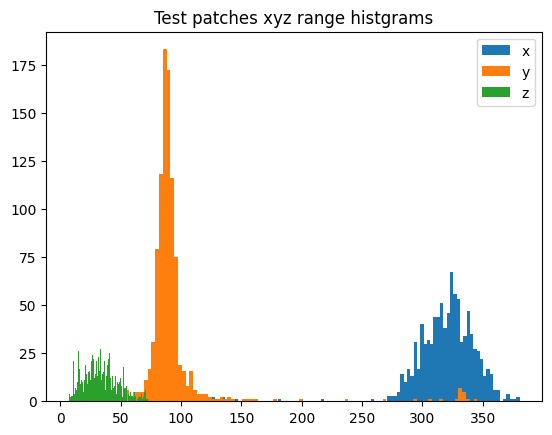

In [44]:
plot_ranges(filename='/home/li/pcl-registration/Datasets/NBP22-mission2-DotsonEast/test/test_patches.npy',
            subset='Test')

patches shape: (1206,)


100%|██████████| 1206/1206 [00:01<00:00, 924.66it/s]


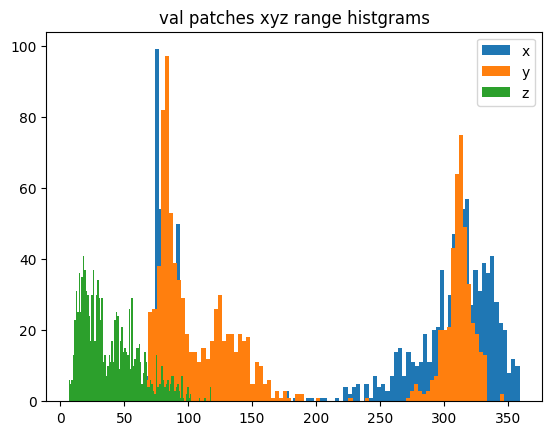

In [46]:
plot_ranges(filename='/home/li/pcl-registration/Datasets/NBP22-mission2-DotsonEast/val/val_patches.npy',
                 subset='val')

patches shape: (470,)


100%|██████████| 470/470 [00:00<00:00, 1790.80it/s]


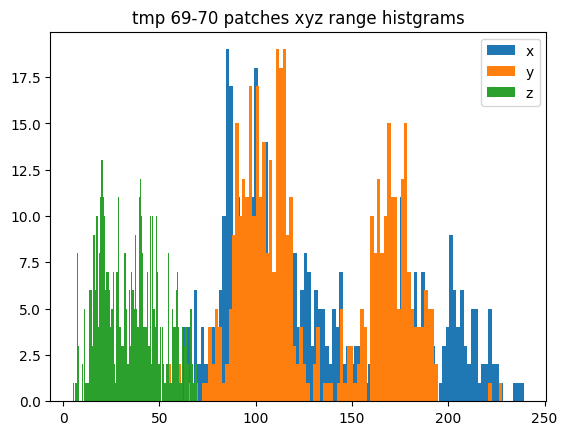

In [49]:
plot_ranges(filename='/home/li/pcl-registration/Datasets/NBP22-mission2-DotsonEast/tmp69-70/tmp69-70_patches.npy',
            subset='tmp 69-70')

# 4. Generate Patches

## 4.1 Generate look up table for ping no -> original file and ping no

In [73]:
def get_filename_and_length_for_subset(included_fileids, subset_name, store=True):
    filename_and_length = []
    print('Filename\t| Pings\t| Cumulative Pings Start\t| Cumulative Pings End\t|')
    cumulative_pings = 0
    for f in sorted(os.listdir('../src/mbes_data/data/nbp22-mission2-dotson-east/pings-npy/')):
        pings = np.load(f'../src/mbes_data/data/nbp22-mission2-dotson-east/pings-npy/{f}')
        if 'EM2040' not in f:
            continue
        filename = int(f.split("-")[1])
        if filename not in included_fileids:
            continue
        num_pings = pings.shape[0]
        print(f'{filename}\t|{num_pings}\t| {cumulative_pings}\t| {cumulative_pings+pings.shape[0]}\t|')
        cumulative_pings += pings.shape[0]
        filename_and_length.append((int(filename), num_pings))

    if store:
        np.save(f'/home/li/pcl-registration/Datasets/NBP22-mission2-DotsonEast/filename_and_length_files_{subset_name}.npy',
                filename_and_length)
    return filename_and_length

tmp_filename_and_length = get_filename_and_length_for_subset([12, 21, 84, 94], subset_name='tmp', store=False)
tmp_filename_and_length_df = pd.DataFrame(tmp_filename_and_length, columns=['Filename', 'Num pings'])
px.line(tmp_filename_and_length_df, x='Filename', y='Num pings')

Filename	| Pings	| Cumulative Pings Start	| Cumulative Pings End	|
12	|2248	| 0	| 2248	|
21	|363	| 2248	| 2611	|
84	|2367	| 2611	| 4978	|
94	|2276	| 4978	| 7254	|


In [77]:
subset_names = ['train', 'val', 'test', 'tmp50-51', 'tmp69-70']
file_ranges = [train_sec, val_sec, test_sec, (50, 51), (69, 70)]
for (subset_name, file_range) in zip(subset_names, file_ranges):
    print(f'Processing {subset_name}...')
    get_filename_and_length_for_subset([i for i in range(file_range[0], file_range[1] + 1)], subset_name=subset_name, store=True)

Processing train...
Filename	| Pings	| Cumulative Pings Start	| Cumulative Pings End	|
12	|2248	| 0	| 2248	|
13	|2263	| 2248	| 4511	|
14	|2308	| 4511	| 6819	|
15	|347	| 6819	| 7166	|
16	|2405	| 7166	| 9571	|
17	|2399	| 9571	| 11970	|
18	|2339	| 11970	| 14309	|
19	|2455	| 14309	| 16764	|
20	|2464	| 16764	| 19228	|
21	|363	| 19228	| 19591	|
22	|2873	| 19591	| 22464	|
23	|2827	| 22464	| 25291	|
24	|2799	| 25291	| 28090	|
25	|2838	| 28090	| 30928	|
26	|2449	| 30928	| 33377	|
27	|2447	| 33377	| 35824	|
28	|719	| 35824	| 36543	|
29	|2383	| 36543	| 38926	|
30	|2460	| 38926	| 41386	|
31	|826	| 41386	| 42212	|
32	|2487	| 42212	| 44699	|
33	|2390	| 44699	| 47089	|
34	|2423	| 47089	| 49512	|
35	|2347	| 49512	| 51859	|
36	|2336	| 51859	| 54195	|
37	|2445	| 54195	| 56640	|
38	|2341	| 56640	| 58981	|
39	|2465	| 58981	| 61446	|
40	|2503	| 61446	| 63949	|
41	|2306	| 63949	| 66255	|
42	|2440	| 66255	| 68695	|
43	|2441	| 68695	| 71136	|
44	|223	| 71136	| 71359	|
45	|2363	| 71359	| 73722	|
46	|2401	| 737

## 4.2 Generate patches and store npz files

In [79]:
from mbes_data.lib.utils import load_config, setup_seed
from easydict import EasyDict as edict
setup_seed(0)

def cumulative_ping_no_to_filename_and_ping_no(target_ping_no, filename_and_length_array):
    """Map a target ping number to the filename and ping number of the original
    15-minute EM2040 files"""
    cumulative_ping_no = 0

    for i, (filename, num_pings) in enumerate(filename_and_length_array):
        cumulative_ping_no += num_pings
        if cumulative_ping_no > target_ping_no:
            return filename, target_ping_no - (cumulative_ping_no - num_pings)
            

def generate_patches(pings_file, config_path,
                     filename_and_length_file):
    config = edict(load_config(config_path))
    pings = np.load(pings_file)
    nbr_pings, nbr_beams, _ = pings.shape
    filename_and_length = np.load(filename_and_length_file)

    parent_folder = os.path.dirname(pings_file)
    patch_folder = os.path.join(parent_folder,
                                f'patches-{config.nbr_pings_per_patch}pings-'
                                f'{config.nbr_beams_per_patch}beams-'
                                f'{config.pings_step}pings_step-'
                                f'{config.beams_step}beams_step')
    if not os.path.exists(patch_folder):
        os.makedirs(patch_folder)
    else:
        print(f'Patch folder {patch_folder} already exists, skipping...')
        return

    ping_start_max = nbr_pings - config.nbr_pings_per_patch + 1
    beam_start_max = nbr_beams - config.nbr_beams_per_patch + 1
    nbr_patches = (np.ceil(ping_start_max / config.pings_step) * np.ceil(beam_start_max / config.beams_step)).astype(int)
    print(f'Generating patches from {pings_file} data with {nbr_pings} pings...')
    print(f'Max ping start: {ping_start_max}, max beam start: {beam_start_max}')
    print(f'Number of patches: {nbr_patches}')
    patch_idx = 0

    for ping_id_start in tqdm(range(0, ping_start_max, config.pings_step)):
        ping_id_end = min(ping_id_start + config.nbr_pings_per_patch, nbr_pings)
        start_filename, start_id_in_file = cumulative_ping_no_to_filename_and_ping_no(ping_id_start, filename_and_length)
        end_filename, end_id_in_file = cumulative_ping_no_to_filename_and_ping_no(ping_id_end, filename_and_length)

        for beam_id_start in range(0, beam_start_max, config.beams_step):
            beam_id_end = min(beam_id_start + config.nbr_beams_per_patch, nbr_beams)

            patch_raw = pings[ping_id_start:ping_id_end,
                        beam_id_start:beam_id_end]

            # Filter data points that are (0, 0, 0), i.e. no data
            patch_raw = patch_raw[~np.all(patch_raw==0, axis=2)].astype(np.float32).reshape(-1, 3)

            np.savez(os.path.join(patch_folder, f'{patch_idx}.npz'),
                     submap=patch_raw,
                     idx=patch_idx,
                     ping_id_start=ping_id_start,
                     ping_id_end=ping_id_end,
                     beam_id_start=beam_id_start,
                     beam_id_end=beam_id_end,
                     start_filename=start_filename,
                     start_id_in_file=start_id_in_file,
                     end_filename=end_filename,
                     end_id_in_file=end_id_in_file)
            patch_idx += 1

In [84]:
subset = 'val'
generate_patches(pings_file=f'../src/mbes_data/data/nbp22-mission2-dotson-east/{subset}/{subset}_pings.npy',
                 config_path='../src/mbes_data/configs/patches_gen.yaml',
                 filename_and_length_file=f'../src/mbes_data/data/nbp22-mission2-dotson-east/filename_and_length_files_{subset}.npy')

  5%|▍         | 57/1206 [00:00<00:02, 563.44it/s]

Generating patches from ../src/mbes_data/data/nbp22-mission2-dotson-east/val/val_pings.npy data with 24218 pings...
Max ping start: 24119, max beam start: 1
Number of patches: 1206


100%|██████████| 1206/1206 [00:02<00:00, 567.75it/s]


In [94]:
test_patch = np.load('../src/mbes_data/data/nbp22-mission2-dotson-east/test/patches-100pings-400beams-20pings_step-400beams_step/900.npz')

In [95]:
test_patch.files

['submap',
 'idx',
 'ping_id_start',
 'ping_id_end',
 'beam_id_start',
 'beam_id_end',
 'start_filename',
 'start_id_in_file',
 'end_filename',
 'end_id_in_file']

In [99]:
test_patch['submap']

array([[4.6623462e+05, 1.7632552e+06, 7.9670001e+02],
       [4.6623509e+05, 1.7632555e+06, 7.9684998e+02],
       [4.6623572e+05, 1.7632556e+06, 7.9690997e+02],
       ...,
       [4.6650125e+05, 1.7633208e+06, 7.8696997e+02],
       [4.6650162e+05, 1.7633209e+06, 7.8671002e+02],
       [4.6650188e+05, 1.7633210e+06, 7.8634998e+02]], dtype=float32)